# Классификация клиентов телеком компании

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Деление-данных-на-выборки" data-toc-modified-id="Деление-данных-на-выборки-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Деление данных на выборки</a></span></li><li><span><a href="#Тестируем-алгоритм-классификации-дерево-решений." data-toc-modified-id="Тестируем-алгоритм-классификации-дерево-решений.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестируем алгоритм классификации дерево решений.</a></span></li><li><span><a href="#Тестируем-алгоритм-классификации--случайный-лес." data-toc-modified-id="Тестируем-алгоритм-классификации--случайный-лес.-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестируем алгоритм классификации  случайный лес.</a></span></li><li><span><a href="#Тестируем-алгоритм-логистическая-регрессия." data-toc-modified-id="Тестируем-алгоритм-логистическая-регрессия.-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестируем алгоритм логистическая регрессия.</a></span></li><li><span><a href="#Проверяем-качество-модели-на-тестовой-выборке" data-toc-modified-id="Проверяем-качество-модели-на-тестовой-выборке-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Проверяем качество модели на тестовой выборке</a></span></li><li><span><a href="#Проверка-на-адекватность-модели." data-toc-modified-id="Проверка-на-адекватность-модели.-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Проверка на адекватность модели.</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Описание проекта

Оператор мобильной связи хочет построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

Поставлена задача построить модель с максимально большим значением accuracy для задачи классификации, которая выберет подходящий тариф. 

В распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы.

## Обзор данных

In [51]:
import pandas as pd
from matplotlib import pyplot as plt 

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

In [27]:
try: 
    df = pd.read_csv('/datasets/users_behavior.csv')
except: 
    df = pd.read_csv('datasets/users_behavior.csv')

In [28]:
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0



**Описание данных**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. 

Известно:

`сalls` — количество звонков,

`minutes` — суммарная длительность звонков в минутах,

`messages` — количество sms-сообщений,

`mb_used` — израсходованный интернет-трафик в Мб,

`is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [30]:
df.is_ultra.mean()

0.30647168637212197

Целевой признак - каким трифом пользуется клиент. Соотношение данных в целевом признаке примерно 30/70 Ультра/Смарт. Для наиболее корректного обучения модели желательно соотношение 50/50, поэтому, вероятно, модели будут давать не наилучший возможный результат.

Т.к. у целевого признака всего 2 значения: 1 и 0, то будем тестировать модели классификации.

Данные готовы к работе.

## Деление данных на выборки

Создаем переменные для признака и целевого признака.

In [31]:
features = df.drop('is_ultra', axis=1)
target = df.is_ultra

Выделим 60% данных для обучающей выборки, остальное раздилим поровну для валидационной и тестовой выборок.

In [32]:
features_train, features_rest, target_train, target_rest = train_test_split(
    features, target, test_size=0.4, random_state=12345)

In [33]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_rest, target_rest, test_size=0.5, random_state=12345)

In [34]:
print('Размеры обучающей выборки:', features_train.shape, target_train.shape)
print('Размеры валидационной выборки:', features_valid.shape, target_valid.shape)
print('Размеры тестовой выборки:', features_test.shape, target_test.shape)

Размеры обучающей выборки: (1928, 4) (1928,)
Размеры валидационной выборки: (643, 4) (643,)
Размеры тестовой выборки: (643, 4) (643,)


## Тестируем алгоритм классификации дерево решений.

Тестируем дерево решений. 

Для этого используем цикл, в котором будем менять гиперпараметр `max_depth`, чтобы выбрать модель с наилучшим результатом.
Наилучший результат для нас - максимальное значение `accuracy`.

In [42]:
# Дерево решений на обучающей выборке
best_model_tree = None
best_result = 0
depth = 0
acc_train_tree = []
for i in range (1,11):
    model =  DecisionTreeClassifier(random_state=12345, max_depth=i)
    model.fit(features_train, target_train)
    predictions = model.predict(features_train)
    result = accuracy_score(target_train, predictions)
    acc_train_tree.append(result)
    print('Максимальная глубина:', i, 'Accuracy:', result)
    if result > best_result:
        best_model_tree = model 
        best_result = result 
        depth = i
print()
print("Accuracy наилучшей модели на обучающей выборке:", best_result)
print("Максимальная глубина:", depth)

Максимальная глубина: 1 Accuracy: 0.7577800829875518
Максимальная глубина: 2 Accuracy: 0.7878630705394191
Максимальная глубина: 3 Accuracy: 0.8075726141078838
Максимальная глубина: 4 Accuracy: 0.8106846473029046
Максимальная глубина: 5 Accuracy: 0.8200207468879668
Максимальная глубина: 6 Accuracy: 0.8376556016597511
Максимальная глубина: 7 Accuracy: 0.8558091286307054
Максимальная глубина: 8 Accuracy: 0.8625518672199171
Максимальная глубина: 9 Accuracy: 0.8812240663900415
Максимальная глубина: 10 Accuracy: 0.8890041493775933

Accuracy наилучшей модели на обучающей выборке: 0.8890041493775933
Максимальная глубина: 10


In [43]:
# Дерево решений на валидационной выборке
best_model_tree = None
best_result = 0
depth = 0
acc_valid_tree = []
for i in range (1,11):
    model =  DecisionTreeClassifier(random_state=12345, max_depth=i)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    acc_valid_tree.append(result)
    print('Максимальная глубина:', i, 'Accuracy:', result)
    if result > best_result:
        best_model_tree = model 
        best_result = result 
        depth = i
print()
print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print("Максимальная глубина:", depth)

Максимальная глубина: 1 Accuracy: 0.7542768273716952
Максимальная глубина: 2 Accuracy: 0.7822706065318819
Максимальная глубина: 3 Accuracy: 0.7853810264385692
Максимальная глубина: 4 Accuracy: 0.7791601866251944
Максимальная глубина: 5 Accuracy: 0.7791601866251944
Максимальная глубина: 6 Accuracy: 0.7838258164852255
Максимальная глубина: 7 Accuracy: 0.7822706065318819
Максимальная глубина: 8 Accuracy: 0.7791601866251944
Максимальная глубина: 9 Accuracy: 0.7822706065318819
Максимальная глубина: 10 Accuracy: 0.7744945567651633

Accuracy наилучшей модели на валидационной выборке: 0.7853810264385692
Максимальная глубина: 3


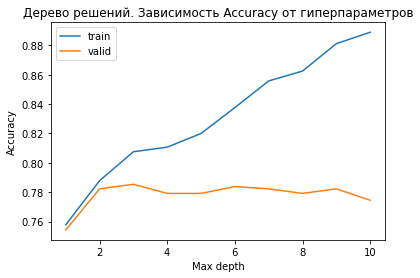

In [60]:
depth = list(range(1,11))
plt.plot(depth, acc_train_tree, label='train')   
plt.plot(depth, acc_valid_tree, label='valid')
plt.legend()
plt.title("Дерево решений. Зависимость Acсuracy от гиперпараметров")   
plt.ylabel('Accuracy')   
plt.xlabel('Max depth');   

С ростом сложности моделей на обучающем наборе точность растет, а на валидационном - сначала растет, затем снижается из-за переобучения.

## Тестируем алгоритм классификации  случайный лес.

Тестируем случайный лес.

Здесь тоже используем цикл для перебора гиперпараметра `n_estimators` - количество оценщиков. 
По результатам цикла сохраним модель с наилучшим показателем `accuracy`.

In [65]:
# Случайный лес на обучающей выборке
best_model_forest = None
best_result = 0
n_est = 0
acc_train_forest = []
for est in range(1, 30):
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    model.fit(features_train, target_train) 
    result = model.score(features_train, target_train) 
    acc_train_forest.append(result)
    print('Число деревьев:', est, 'Accuracy:', result)
    if result > best_result:
        best_model_forest = model 
        best_result = result 
        n_est = est
print()
print("Accuracy наилучшей модели на обучающей выборке:", best_result)
print("Число деревьев:", n_est)

Число деревьев: 1 Accuracy: 0.9035269709543569
Число деревьев: 2 Accuracy: 0.9097510373443983
Число деревьев: 3 Accuracy: 0.9507261410788381
Число деревьев: 4 Accuracy: 0.946058091286307
Число деревьев: 5 Accuracy: 0.9678423236514523
Число деревьев: 6 Accuracy: 0.9693983402489627
Число деревьев: 7 Accuracy: 0.9787344398340249
Число деревьев: 8 Accuracy: 0.9771784232365145
Число деревьев: 9 Accuracy: 0.983402489626556
Число деревьев: 10 Accuracy: 0.9823651452282157
Число деревьев: 11 Accuracy: 0.9854771784232366
Число деревьев: 12 Accuracy: 0.983402489626556
Число деревьев: 13 Accuracy: 0.9870331950207469
Число деревьев: 14 Accuracy: 0.9844398340248963
Число деревьев: 15 Accuracy: 0.9896265560165975
Число деревьев: 16 Accuracy: 0.9865145228215768
Число деревьев: 17 Accuracy: 0.9906639004149378
Число деревьев: 18 Accuracy: 0.9875518672199171
Число деревьев: 19 Accuracy: 0.9911825726141079
Число деревьев: 20 Accuracy: 0.9891078838174274
Число деревьев: 21 Accuracy: 0.9922199170124482
Числ

In [66]:
# Случайный лес на валидационной выборке
best_model_forest = None
best_result = 0
n_est = 0
acc_valid_forest = [] 
for est in range(1, 30):
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    model.fit(features_train, target_train) 
    result = model.score(features_valid, target_valid) 
    acc_valid_forest.append(result)
    print('Число деревьев:', est, 'Accuracy:', result)
    if result > best_result:
        best_model_forest = model 
        best_result = result 
        n_est = est
print()
print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print("Число деревьев:", n_est)

Число деревьев: 1 Accuracy: 0.7107309486780715
Число деревьев: 2 Accuracy: 0.7636080870917574
Число деревьев: 3 Accuracy: 0.7387247278382582
Число деревьев: 4 Accuracy: 0.7713841368584758
Число деревьев: 5 Accuracy: 0.749611197511664
Число деревьев: 6 Accuracy: 0.7807153965785381
Число деревьев: 7 Accuracy: 0.7682737169517885
Число деревьев: 8 Accuracy: 0.7822706065318819
Число деревьев: 9 Accuracy: 0.7729393468118196
Число деревьев: 10 Accuracy: 0.7853810264385692
Число деревьев: 11 Accuracy: 0.7838258164852255
Число деревьев: 12 Accuracy: 0.7869362363919129
Число деревьев: 13 Accuracy: 0.7822706065318819
Число деревьев: 14 Accuracy: 0.7838258164852255
Число деревьев: 15 Accuracy: 0.7838258164852255
Число деревьев: 16 Accuracy: 0.7869362363919129
Число деревьев: 17 Accuracy: 0.7869362363919129
Число деревьев: 18 Accuracy: 0.7931570762052877
Число деревьев: 19 Accuracy: 0.7884914463452566
Число деревьев: 20 Accuracy: 0.7869362363919129
Число деревьев: 21 Accuracy: 0.7931570762052877
Чи

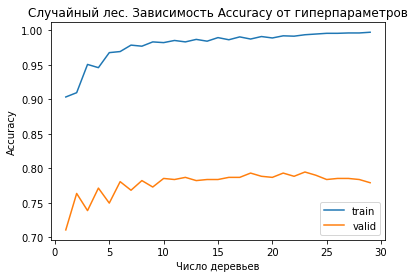

In [67]:
est = list(range(1, 30))
plt.plot(est, acc_train_forest, label='train')   
plt.plot(est, acc_valid_forest, label='valid')
plt.legend()
plt.title("Случайный лес. Зависимость Acсuracy от гиперпараметров")   
plt.ylabel('Accuracy')   
plt.xlabel('Число деревьев');   

В случайном лесе так же с ростом числа деревьев точность на обучающей выборке растет, а на валидацинной - сначала растет, затем снижается из-за переобучения.

## Тестируем алгоритм логистическая регрессия.

Протестируем логистическую регрессию. Здесь из гиперпараметров только фиксация псевдослучайности, так что перебирать в цикле ничего не будем.

In [39]:
model_logreg = LogisticRegression(random_state=12345) 
model_logreg.fit(features_train, target_train) 
predictions = model.predict(features_valid) 
accuracy = model_logreg.score(features_valid, target_valid) 
print('Accuracy в логистической регрессии:', accuracy)

Accuracy в логистической регрессии: 0.7107309486780715


Наилучшее значение accuracy показал случайный лес с 23 деревьями - **0.795**. На втором месте дерево решений с глубиной 3 - **0.785**.

## Проверяем качество модели на тестовой выборке

In [40]:
# Проверяем на лучшей модели случайного леса тестовую выборку.
result = best_model_forest.score(features_test, target_test)
print(result)

0.7807153965785381


Результат выше, чем требуемый 0.75.

## Проверка на адекватность модели.

Для проверки модели на адекватность нужно проверить, лучше ли она, чем просто случайные значения. Для такой оценки используют фиктивный классификатор DummyClassifier. 

In [41]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=12345)
dummy_clf.fit(features_train, target_train)
print('Accuracy Dummy-модели на тестовой выборке:', dummy_clf.score(features_test, target_test))

Accuracy Dummy-модели на тестовой выборке: 0.6842923794712286


Значения accuracy у Dummy-модели ниже, чем у полученных ранее моделей, значит модель можно считать адекватной.

## Вывод

Мы построили модели для классификации, которые помогли бы оператору "Мегалайн", пронализировав поведение клиентов, подобрать им подходящий тариф: "Ультра" или "Смарт". 

Наилучшее значение `accuracy` на валидационной выборке **0,795** показала модель случайный лес с количеством деревьев 23.
На тестовой выборке результат оказался 0,78, что выше требуемого 0, 75. Проверка модели с помощью фиктивного классификатора показала, что она адекватна. 